In [13]:
# ライブラリのインポート
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score
from sklearn.utils import class_weight
from sklearn.ensemble import BaggingClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb  #lightGBMを入れる
import xgboost as xgb  #XGboostを入れる
from sklearn.linear_model import LogisticRegression  # ロジスティック回帰を入れる

import shap

# データの読み込み
df = pd.read_excel('lightGBM_data_standard.xlsx')
df_lr = pd.read_excel('補完データ_test07.xlsx') #　ロジスティック回帰のデータ読み込み

# カテゴリ変数のデータ型を変換
cat_cols = ['FBS', 'HbA1c', 'US', 'HbA1c_NGSP']
df[cat_cols] = df[cat_cols].astype(str)
df_lr[cat_cols] = df_lr[cat_cols].astype(str)


# ラベルエンコーディングを実行
le = LabelEncoder()
df[cat_cols] = df[cat_cols].apply(le.fit_transform)
df_lr[cat_cols] = df_lr[cat_cols].apply(le.fit_transform)


# 特徴量とターゲットに分割
X = df.drop('T2db', axis=1)
y = df['T2db']

X_lr = df_lr.drop('T2db', axis=1)
y_lr = df_lr['T2db']

# 特定の列を削除
# df = df.drop(['TG', 'HDL', 'LDL', 'GOT', 'GPT', 'γ_GT', 'Ht', 'Hb', 'RBC', 'chewing', 'Medication1_Blood Pressure', 'Time of blood collection _after meal', 'Medication2_Blood Sugar', 'Eating style3_midnight snack', 'One-year weight change', 'HbA1c', 'FBS', 'US', 'HbA1c_NGSP'], axis=1)

# 削除した結果を反映した特徴量を再作成
# X = df.drop('T2db', axis=1)

# アンダーサンプリング
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X, y)
X_resampled_lr, y_resampled_lr = rus.fit_resample(X_lr, y_lr)

# バギングによるモデルの学習と評価
# lightGBM
accuracy_scores = []
f1_scores = []
precision_scores = []  # 適合率を格納するリスト
confusion_matrices = []

# XGboost
accuracy_scores_xgb = []
f1_scores_xgb = []
precision_scores_xgb = []  # 適合率を格納するリスト
confusion_matrices_xgb = []

# ロジスティック回帰
accuracy_scores_lr = []
f1_scores_lr = []
precision_scores_lr = []  # 適合率を格納するリスト
confusion_matrices_lr = []
auc_scores_lr = []

n_estimators = 10  # バギングの回数

for _ in range(n_estimators):
    # 学習データとテストデータに分割
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, shuffle=True, stratify=y_resampled, random_state=0)
    print('X_trainの形状：', X_train.shape, ' y_trainの形状：', y_train.shape, ' X_testの形状：', X_test.shape, ' y_testの形状：', y_test.shape)
    
    # 学習データとテストデータに分割（ロジスティック回帰）
    X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_resampled_lr, y_resampled_lr, test_size=0.3, shuffle=True, stratify=y_resampled, random_state=0)

    # LightGBM用のデータセットを作成
    lgb_train = lgb.Dataset(X_train, y_train)

    # xgboost用のデータセットを作成
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # ハイパーパラメータの設定
    params = {
        'objective': 'binary',
        'num_leaves': 5,
        'seed': 0,
        'verbose': -1,
    }

    params_xgb = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'max_depth': 2,
        'learning_rate': 0.8,
        'base_score': 0.5,
        'min_split_loss': 0,
        'reg_lambda': 0,
        'reg_alpha': 0,
        'seed': 0,
    }

    # LightGBMモデルの学習
    model = lgb.train(params,
                      lgb_train,
                      num_boost_round=500,
                      valid_sets=[lgb_train],
                      valid_names=['train'],
                      early_stopping_rounds=20)

    # xgboostモデルの学習
    model_xgb = xgb.train(params_xgb,
                          dtrain,
                          num_boost_round=500,
                          early_stopping_rounds=20,
                          evals=[(dtest, 'test')])
    
    # ロジスティック回帰の学習
    model_lr = LogisticRegression()
    model_lr.fit(X_train_lr, y_train_lr)
    

    # テストデータの予測と評価(lightGBM)
    y_test_pred_proba = model.predict(X_test)  # ラベル1の確率
    y_test_pred = np.round(y_test_pred_proba)  # 確率をラベル0 or 1に変換
    ac_score = accuracy_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)  # 適合率の計算

    # 混同行列(lightGBM)
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 20})
    plt.xlabel('pred')
    plt.ylabel('label')
    plt.savefig('confusion_matrix.png', dpi=300)
    plt.close()
    accuracy_scores.append(ac_score)
    f1_scores.append(f1)
    precision_scores.append(precision)  # 適合率
    confusion_matrices.append(cm)

    # XGboostモデルのテストデータの予測と評価
    y_test_pred_proba_xgb = model_xgb.predict(dtest)  # ラベル1の確率
    y_test_pred_xgb = np.round(y_test_pred_proba_xgb)  # 確率をラベル0 or 1に変換
    ac_score_xgb = accuracy_score(y_test, y_test_pred_xgb)
    f1_xgb = f1_score(y_test, y_test_pred_xgb)
    precision_xgb = precision_score(y_test, y_test_pred_xgb)  # 適合率の計算
    
    # 混同行列(XGboost)
    cm_xgb = confusion_matrix(y_test, y_test_pred_xgb)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 20})
    plt.xlabel('pred')
    plt.ylabel('label')
    plt.savefig('confusion_matrix_xgb.png', dpi=300)
    plt.close()
    accuracy_scores_xgb.append(ac_score_xgb)
    f1_scores_xgb.append(f1_xgb)
    precision_scores_xgb.append(precision_xgb)  # 適合率
    confusion_matrices_xgb.append(cm_xgb)
    
    
    #ロジスティック回帰による予測と評価
    y_test_pred_proba_lr = model.predict(X_test_lr)  # ラベル1の確率
    y_test_pred_lr = np.round(y_test_pred_proba_lr)  # 確率をラベル0 or 1に変換
    ac_score_lr = accuracy_score(y_test_lr, y_test_pred_lr)
    f1_lr = f1_score(y_test_lr, y_test_pred_lr)
    precision_lr = precision_score(y_test_lr, y_test_pred_lr)  # 適合率の計算

    # 混同行列(ロジスティック回帰)
    cm_lr = confusion_matrix(y_test_lr, y_test_pred_lr)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 20})
    plt.xlabel('pred')
    plt.ylabel('label')
    plt.savefig('confusion_matrix_lr.png', dpi=300)
    plt.close()
    accuracy_scores_lr.append(ac_score_lr)
    f1_scores_lr.append(f1_lr)
    precision_scores_lr.append(precision_lr)  # 適合率
    confusion_matrices_lr.append(cm_lr)
    

# 結果の表示
print('LightGBM accuracy = %.2f' % np.mean(accuracy_scores))
print('LightGBM F1-score = %.2f' % np.mean(f1_scores))
print('LightGBM Precision = %.2f' % np.mean(precision_scores))
# print('LightGBM AUC = %.2f' % np.mean(auc_scores))

print('XGboost accuracy = %.2f' % np.mean(accuracy_scores_xgb))
print('XGboost F1-score = %.2f' % np.mean(f1_scores_xgb))
print('XGboost Precision = %.2f' % np.mean(precision_scores_xgb))
# print('XGboost AUC = %.2f' % np.mean(auc_scores_xgb))

print('Logistic Regression accuracy = %.2f' % np.mean(accuracy_scores_lr))
print('Logistic Regression F1-score = %.2f' % np.mean(f1_scores_lr))
print('Logistic Regression Precision = %.2f' % np.mean(precision_scores_lr))
# print('Logistic Regression AUC = %.2f' % np.mean(auc_scores_lr))

X_trainの形状： (646, 43)  y_trainの形状： (646,)  X_testの形状： (278, 43)  y_testの形状： (278,)
[1]	train's binary_logloss: 0.645979
Training until validation scores don't improve for 20 rounds
[2]	train's binary_logloss: 0.607469
[3]	train's binary_logloss: 0.575587
[4]	train's binary_logloss: 0.54889
[5]	train's binary_logloss: 0.524775
[6]	train's binary_logloss: 0.505158
[7]	train's binary_logloss: 0.487333
[8]	train's binary_logloss: 0.473403
[9]	train's binary_logloss: 0.459756
[10]	train's binary_logloss: 0.447863
[11]	train's binary_logloss: 0.437382
[12]	train's binary_logloss: 0.42888
[13]	train's binary_logloss: 0.420697
[14]	train's binary_logloss: 0.413379
[15]	train's binary_logloss: 0.407086
[16]	train's binary_logloss: 0.400418
[17]	train's binary_logloss: 0.394532
[18]	train's binary_logloss: 0.389788
[19]	train's binary_logloss: 0.384675
[20]	train's binary_logloss: 0.380166
[21]	train's binary_logloss: 0.375858
[22]	train's binary_logloss: 0.371429
[23]	train's binary_logloss: 0.

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


X_trainの形状： (646, 43)  y_trainの形状： (646,)  X_testの形状： (278, 43)  y_testの形状： (278,)
[1]	train's binary_logloss: 0.645979
Training until validation scores don't improve for 20 rounds
[2]	train's binary_logloss: 0.607469
[3]	train's binary_logloss: 0.575587
[4]	train's binary_logloss: 0.54889
[5]	train's binary_logloss: 0.524775
[6]	train's binary_logloss: 0.505158
[7]	train's binary_logloss: 0.487333
[8]	train's binary_logloss: 0.473403
[9]	train's binary_logloss: 0.459756
[10]	train's binary_logloss: 0.447863
[11]	train's binary_logloss: 0.437382
[12]	train's binary_logloss: 0.42888
[13]	train's binary_logloss: 0.420697
[14]	train's binary_logloss: 0.413379
[15]	train's binary_logloss: 0.407086
[16]	train's binary_logloss: 0.400418
[17]	train's binary_logloss: 0.394532
[18]	train's binary_logloss: 0.389788
[19]	train's binary_logloss: 0.384675
[20]	train's binary_logloss: 0.380166
[21]	train's binary_logloss: 0.375858
[22]	train's binary_logloss: 0.371429
[23]	train's binary_logloss: 0.

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


X_trainの形状： (646, 43)  y_trainの形状： (646,)  X_testの形状： (278, 43)  y_testの形状： (278,)
[1]	train's binary_logloss: 0.645979
Training until validation scores don't improve for 20 rounds
[2]	train's binary_logloss: 0.607469
[3]	train's binary_logloss: 0.575587
[4]	train's binary_logloss: 0.54889
[5]	train's binary_logloss: 0.524775
[6]	train's binary_logloss: 0.505158
[7]	train's binary_logloss: 0.487333
[8]	train's binary_logloss: 0.473403
[9]	train's binary_logloss: 0.459756
[10]	train's binary_logloss: 0.447863
[11]	train's binary_logloss: 0.437382
[12]	train's binary_logloss: 0.42888
[13]	train's binary_logloss: 0.420697
[14]	train's binary_logloss: 0.413379
[15]	train's binary_logloss: 0.407086
[16]	train's binary_logloss: 0.400418
[17]	train's binary_logloss: 0.394532
[18]	train's binary_logloss: 0.389788
[19]	train's binary_logloss: 0.384675
[20]	train's binary_logloss: 0.380166
[21]	train's binary_logloss: 0.375858
[22]	train's binary_logloss: 0.371429
[23]	train's binary_logloss: 0.

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


X_trainの形状： (646, 43)  y_trainの形状： (646,)  X_testの形状： (278, 43)  y_testの形状： (278,)
[1]	train's binary_logloss: 0.645979
Training until validation scores don't improve for 20 rounds
[2]	train's binary_logloss: 0.607469
[3]	train's binary_logloss: 0.575587
[4]	train's binary_logloss: 0.54889
[5]	train's binary_logloss: 0.524775
[6]	train's binary_logloss: 0.505158
[7]	train's binary_logloss: 0.487333
[8]	train's binary_logloss: 0.473403
[9]	train's binary_logloss: 0.459756
[10]	train's binary_logloss: 0.447863
[11]	train's binary_logloss: 0.437382
[12]	train's binary_logloss: 0.42888
[13]	train's binary_logloss: 0.420697
[14]	train's binary_logloss: 0.413379
[15]	train's binary_logloss: 0.407086
[16]	train's binary_logloss: 0.400418
[17]	train's binary_logloss: 0.394532
[18]	train's binary_logloss: 0.389788
[19]	train's binary_logloss: 0.384675
[20]	train's binary_logloss: 0.380166
[21]	train's binary_logloss: 0.375858
[22]	train's binary_logloss: 0.371429
[23]	train's binary_logloss: 0.

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


X_trainの形状： (646, 43)  y_trainの形状： (646,)  X_testの形状： (278, 43)  y_testの形状： (278,)
[1]	train's binary_logloss: 0.645979
Training until validation scores don't improve for 20 rounds
[2]	train's binary_logloss: 0.607469
[3]	train's binary_logloss: 0.575587
[4]	train's binary_logloss: 0.54889
[5]	train's binary_logloss: 0.524775
[6]	train's binary_logloss: 0.505158
[7]	train's binary_logloss: 0.487333
[8]	train's binary_logloss: 0.473403
[9]	train's binary_logloss: 0.459756
[10]	train's binary_logloss: 0.447863
[11]	train's binary_logloss: 0.437382
[12]	train's binary_logloss: 0.42888
[13]	train's binary_logloss: 0.420697
[14]	train's binary_logloss: 0.413379
[15]	train's binary_logloss: 0.407086
[16]	train's binary_logloss: 0.400418
[17]	train's binary_logloss: 0.394532
[18]	train's binary_logloss: 0.389788
[19]	train's binary_logloss: 0.384675
[20]	train's binary_logloss: 0.380166
[21]	train's binary_logloss: 0.375858
[22]	train's binary_logloss: 0.371429
[23]	train's binary_logloss: 0.

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


X_trainの形状： (646, 43)  y_trainの形状： (646,)  X_testの形状： (278, 43)  y_testの形状： (278,)
[1]	train's binary_logloss: 0.645979
Training until validation scores don't improve for 20 rounds
[2]	train's binary_logloss: 0.607469
[3]	train's binary_logloss: 0.575587
[4]	train's binary_logloss: 0.54889
[5]	train's binary_logloss: 0.524775
[6]	train's binary_logloss: 0.505158
[7]	train's binary_logloss: 0.487333
[8]	train's binary_logloss: 0.473403
[9]	train's binary_logloss: 0.459756
[10]	train's binary_logloss: 0.447863
[11]	train's binary_logloss: 0.437382
[12]	train's binary_logloss: 0.42888
[13]	train's binary_logloss: 0.420697
[14]	train's binary_logloss: 0.413379
[15]	train's binary_logloss: 0.407086
[16]	train's binary_logloss: 0.400418
[17]	train's binary_logloss: 0.394532
[18]	train's binary_logloss: 0.389788
[19]	train's binary_logloss: 0.384675
[20]	train's binary_logloss: 0.380166
[21]	train's binary_logloss: 0.375858
[22]	train's binary_logloss: 0.371429
[23]	train's binary_logloss: 0.

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


X_trainの形状： (646, 43)  y_trainの形状： (646,)  X_testの形状： (278, 43)  y_testの形状： (278,)
[1]	train's binary_logloss: 0.645979
Training until validation scores don't improve for 20 rounds
[2]	train's binary_logloss: 0.607469
[3]	train's binary_logloss: 0.575587
[4]	train's binary_logloss: 0.54889
[5]	train's binary_logloss: 0.524775
[6]	train's binary_logloss: 0.505158
[7]	train's binary_logloss: 0.487333
[8]	train's binary_logloss: 0.473403
[9]	train's binary_logloss: 0.459756
[10]	train's binary_logloss: 0.447863
[11]	train's binary_logloss: 0.437382
[12]	train's binary_logloss: 0.42888
[13]	train's binary_logloss: 0.420697
[14]	train's binary_logloss: 0.413379
[15]	train's binary_logloss: 0.407086
[16]	train's binary_logloss: 0.400418
[17]	train's binary_logloss: 0.394532
[18]	train's binary_logloss: 0.389788
[19]	train's binary_logloss: 0.384675
[20]	train's binary_logloss: 0.380166
[21]	train's binary_logloss: 0.375858
[22]	train's binary_logloss: 0.371429
[23]	train's binary_logloss: 0.

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


X_trainの形状： (646, 43)  y_trainの形状： (646,)  X_testの形状： (278, 43)  y_testの形状： (278,)
[1]	train's binary_logloss: 0.645979
Training until validation scores don't improve for 20 rounds
[2]	train's binary_logloss: 0.607469
[3]	train's binary_logloss: 0.575587
[4]	train's binary_logloss: 0.54889
[5]	train's binary_logloss: 0.524775
[6]	train's binary_logloss: 0.505158
[7]	train's binary_logloss: 0.487333
[8]	train's binary_logloss: 0.473403
[9]	train's binary_logloss: 0.459756
[10]	train's binary_logloss: 0.447863
[11]	train's binary_logloss: 0.437382
[12]	train's binary_logloss: 0.42888
[13]	train's binary_logloss: 0.420697
[14]	train's binary_logloss: 0.413379
[15]	train's binary_logloss: 0.407086
[16]	train's binary_logloss: 0.400418
[17]	train's binary_logloss: 0.394532
[18]	train's binary_logloss: 0.389788
[19]	train's binary_logloss: 0.384675
[20]	train's binary_logloss: 0.380166
[21]	train's binary_logloss: 0.375858
[22]	train's binary_logloss: 0.371429
[23]	train's binary_logloss: 0.

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


X_trainの形状： (646, 43)  y_trainの形状： (646,)  X_testの形状： (278, 43)  y_testの形状： (278,)
[1]	train's binary_logloss: 0.645979
Training until validation scores don't improve for 20 rounds
[2]	train's binary_logloss: 0.607469
[3]	train's binary_logloss: 0.575587
[4]	train's binary_logloss: 0.54889
[5]	train's binary_logloss: 0.524775
[6]	train's binary_logloss: 0.505158
[7]	train's binary_logloss: 0.487333
[8]	train's binary_logloss: 0.473403
[9]	train's binary_logloss: 0.459756
[10]	train's binary_logloss: 0.447863
[11]	train's binary_logloss: 0.437382
[12]	train's binary_logloss: 0.42888
[13]	train's binary_logloss: 0.420697
[14]	train's binary_logloss: 0.413379
[15]	train's binary_logloss: 0.407086
[16]	train's binary_logloss: 0.400418
[17]	train's binary_logloss: 0.394532
[18]	train's binary_logloss: 0.389788
[19]	train's binary_logloss: 0.384675
[20]	train's binary_logloss: 0.380166
[21]	train's binary_logloss: 0.375858
[22]	train's binary_logloss: 0.371429
[23]	train's binary_logloss: 0.

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


X_trainの形状： (646, 43)  y_trainの形状： (646,)  X_testの形状： (278, 43)  y_testの形状： (278,)
[1]	train's binary_logloss: 0.645979
Training until validation scores don't improve for 20 rounds
[2]	train's binary_logloss: 0.607469
[3]	train's binary_logloss: 0.575587
[4]	train's binary_logloss: 0.54889
[5]	train's binary_logloss: 0.524775
[6]	train's binary_logloss: 0.505158
[7]	train's binary_logloss: 0.487333
[8]	train's binary_logloss: 0.473403
[9]	train's binary_logloss: 0.459756
[10]	train's binary_logloss: 0.447863
[11]	train's binary_logloss: 0.437382
[12]	train's binary_logloss: 0.42888
[13]	train's binary_logloss: 0.420697
[14]	train's binary_logloss: 0.413379
[15]	train's binary_logloss: 0.407086
[16]	train's binary_logloss: 0.400418
[17]	train's binary_logloss: 0.394532
[18]	train's binary_logloss: 0.389788
[19]	train's binary_logloss: 0.384675
[20]	train's binary_logloss: 0.380166
[21]	train's binary_logloss: 0.375858
[22]	train's binary_logloss: 0.371429
[23]	train's binary_logloss: 0.

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LightGBM accuracy = 0.79
LightGBM F1-score = 0.78
LightGBM Precision = 0.80
XGboost accuracy = 0.77
XGboost F1-score = 0.76
XGboost Precision = 0.78
Logistic Regression accuracy = 0.67
Logistic Regression F1-score = 0.68
Logistic Regression Precision = 0.65


## 血液データ削除

In [9]:
# ライブラリのインポート
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score
from sklearn.utils import class_weight
from sklearn.ensemble import BaggingClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb  #lightGBMを入れる
import xgboost as xgb  #XGboostを入れる
from sklearn.linear_model import LogisticRegression  # ロジスティック回帰を入れる

import shap

# データの読み込み
df = pd.read_excel('lightGBM_data_standard.xlsx')
df_lr = pd.read_excel('補完データ_test07.xlsx') #　ロジスティック回帰のデータ読み込み

# カテゴリ変数のデータ型を変換
cat_cols = ['FBS', 'HbA1c', 'US', 'HbA1c_NGSP']
df[cat_cols] = df[cat_cols].astype(str)
df_lr[cat_cols] = df_lr[cat_cols].astype(str)


# ラベルエンコーディングを実行
le = LabelEncoder()
df[cat_cols] = df[cat_cols].apply(le.fit_transform)
df_lr[cat_cols] = df_lr[cat_cols].apply(le.fit_transform)


# 特徴量とターゲットに分割
X = df.drop('T2db', axis=1)
y = df['T2db']

X_lr = df_lr.drop('T2db', axis=1)
y_lr = df_lr['T2db']

# 特定の列を削除
df = df.drop(['TG', 'HDL', 'LDL', 'GOT', 'GPT', 'γ_GT', 'Ht', 'Hb', 'RBC', 'chewing', 'Medication1_Blood Pressure', 'Time of blood collection _after meal', 'Medication2_Blood Sugar', 'Eating style3_midnight snack', 'One-year weight change', 'HbA1c', 'FBS', 'US', 'HbA1c_NGSP'], axis=1)
df_lr = df_lr.drop(['TG', 'HDL', 'LDL', 'GOT', 'GPT', 'γ_GT', 'Ht', 'Hb', 'RBC', 'chewing', 'Medication1_Blood Pressure', 'Time of blood collection _after meal', 'Medication2_Blood Sugar', 'Eating style3_midnight snack', 'One-year weight change', 'HbA1c', 'FBS', 'US', 'HbA1c_NGSP'], axis=1)

# 削除した結果を反映した特徴量を再作成
X = df.drop('T2db', axis=1)
X_lr = df_lr.drop('T2db', axis=1)

# アンダーサンプリング
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X, y)
X_resampled_lr, y_resampled_lr = rus.fit_resample(X_lr, y_lr)

# バギングによるモデルの学習と評価
# lightGBM
accuracy_scores = []
f1_scores = []
precision_scores = []  # 適合率を格納するリスト
confusion_matrices = []

# XGboost
accuracy_scores_xgb = []
f1_scores_xgb = []
precision_scores_xgb = []  # 適合率を格納するリスト
confusion_matrices_xgb = []

# ロジスティック回帰
accuracy_scores_lr = []
f1_scores_lr = []
precision_scores_lr = []  # 適合率を格納するリスト
confusion_matrices_lr = []
auc_scores_lr = []

n_estimators = 10  # バギングの回数

for _ in range(n_estimators):
    # 学習データとテストデータに分割
    X_train_not, X_test_not, y_train_not, y_test_not = train_test_split(X_resampled, y_resampled, test_size=0.3, shuffle=True, stratify=y_resampled, random_state=0)
    print('X_trainの形状：', X_train.shape, ' y_trainの形状：', y_train.shape, ' X_testの形状：', X_test.shape, ' y_testの形状：', y_test.shape)
    
    # 学習データとテストデータに分割（ロジスティック回帰）
    X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_resampled_lr, y_resampled_lr, test_size=0.3, shuffle=True, stratify=y_resampled, random_state=0)

    # LightGBM用のデータセットを作成
    lgb_train = lgb.Dataset(X_train, y_train)

    # xgboost用のデータセットを作成
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # ハイパーパラメータの設定
    params = {
        'objective': 'binary',
        'num_leaves': 5,
        'seed': 0,
        'verbose': -1,
    }

    params_xgb = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'max_depth': 2,
        'learning_rate': 0.8,
        'base_score': 0.5,
        'min_split_loss': 0,
        'reg_lambda': 0,
        'reg_alpha': 0,
        'seed': 0,
    }

    # LightGBMモデルの学習
    model = lgb.train(params,
                      lgb_train,
                      num_boost_round=500,
                      valid_sets=[lgb_train],
                      valid_names=['train'],
                      early_stopping_rounds=20)

    # xgboostモデルの学習
    model_xgb = xgb.train(params_xgb,
                          dtrain,
                          num_boost_round=500,
                          early_stopping_rounds=20,
                          evals=[(dtest, 'test')])
    
    # ロジスティック回帰の学習
    model_lr = LogisticRegression()
    model_lr.fit(X_train_lr, y_train_lr)
    

    # テストデータの予測と評価(lightGBM)
    y_test_pred_proba = model.predict(X_test)  # ラベル1の確率
    y_test_pred = np.round(y_test_pred_proba)  # 確率をラベル0 or 1に変換
    ac_score = accuracy_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)  # 適合率の計算

    # 混同行列(lightGBM)
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 20})
    plt.xlabel('pred')
    plt.ylabel('label')
    plt.savefig('confusion_matrix.png', dpi=300)
    plt.close()
    accuracy_scores.append(ac_score)
    f1_scores.append(f1)
    precision_scores.append(precision)  # 適合率
    confusion_matrices.append(cm)

    # XGboostモデルのテストデータの予測と評価
    y_test_pred_proba_xgb = model_xgb.predict(dtest)  # ラベル1の確率
    y_test_pred_xgb = np.round(y_test_pred_proba_xgb)  # 確率をラベル0 or 1に変換
    ac_score_xgb = accuracy_score(y_test, y_test_pred_xgb)
    f1_xgb = f1_score(y_test, y_test_pred_xgb)
    precision_xgb = precision_score(y_test, y_test_pred_xgb)  # 適合率の計算
    
    # 混同行列(XGboost)
    cm_xgb = confusion_matrix(y_test, y_test_pred_xgb)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 20})
    plt.xlabel('pred')
    plt.ylabel('label')
    plt.savefig('confusion_matrix_xgb.png', dpi=300)
    plt.close()
    accuracy_scores_xgb.append(ac_score_xgb)
    f1_scores_xgb.append(f1_xgb)
    precision_scores_xgb.append(precision_xgb)  # 適合率
    confusion_matrices_xgb.append(cm_xgb)
    
    
    #ロジスティック回帰による予測と評価
    y_test_pred_proba_lr = model.predict(X_test_lr)  # ラベル1の確率
    y_test_pred_lr = np.round(y_test_pred_proba_lr)  # 確率をラベル0 or 1に変換
    ac_score_lr = accuracy_score(y_test_lr, y_test_pred_lr)
    f1_lr = f1_score(y_test_lr, y_test_pred_lr)
    precision_lr = precision_score(y_test_lr, y_test_pred_lr)  # 適合率の計算

    # 混同行列(ロジスティック回帰)
    cm_lr = confusion_matrix(y_test_lr, y_test_pred_lr)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 20})
    plt.xlabel('pred')
    plt.ylabel('label')
    plt.savefig('confusion_matrix_lr.png', dpi=300)
    plt.close()
    accuracy_scores_lr.append(ac_score_lr)
    f1_scores_lr.append(f1_lr)
    precision_scores_lr.append(precision_lr)  # 適合率
    confusion_matrices_lr.append(cm_lr)
    

# 結果の表示
print('LightGBM accuracy = %.2f' % np.mean(accuracy_scores))
print('LightGBM F1-score = %.2f' % np.mean(f1_scores))
print('LightGBM Precision = %.2f' % np.mean(precision_scores))
# print('LightGBM AUC = %.2f' % np.mean(auc_scores))

print('XGboost accuracy = %.2f' % np.mean(accuracy_scores_xgb))
print('XGboost F1-score = %.2f' % np.mean(f1_scores_xgb))
print('XGboost Precision = %.2f' % np.mean(precision_scores_xgb))
# print('XGboost AUC = %.2f' % np.mean(auc_scores_xgb))

print('Logistic Regression accuracy = %.2f' % np.mean(accuracy_scores_lr))
print('Logistic Regression F1-score = %.2f' % np.mean(f1_scores_lr))
print('Logistic Regression Precision = %.2f' % np.mean(precision_scores_lr))
# print('Logistic Regression AUC = %.2f' % np.mean(auc_scores_lr))

X_trainの形状： (646, 24)  y_trainの形状： (646,)  X_testの形状： (278, 24)  y_testの形状： (278,)
[1]	train's binary_logloss: 0.662906
Training until validation scores don't improve for 20 rounds
[2]	train's binary_logloss: 0.638297
[3]	train's binary_logloss: 0.617479
[4]	train's binary_logloss: 0.600501
[5]	train's binary_logloss: 0.585878
[6]	train's binary_logloss: 0.573603
[7]	train's binary_logloss: 0.562965
[8]	train's binary_logloss: 0.553485
[9]	train's binary_logloss: 0.545568
[10]	train's binary_logloss: 0.538341
[11]	train's binary_logloss: 0.53218
[12]	train's binary_logloss: 0.526888
[13]	train's binary_logloss: 0.521507
[14]	train's binary_logloss: 0.516283
[15]	train's binary_logloss: 0.511686
[16]	train's binary_logloss: 0.507458
[17]	train's binary_logloss: 0.502668
[18]	train's binary_logloss: 0.498687
[19]	train's binary_logloss: 0.494656
[20]	train's binary_logloss: 0.491561
[21]	train's binary_logloss: 0.488351
[22]	train's binary_logloss: 0.485573
[23]	train's binary_logloss: 0

## ロジスティック回帰

In [ ]:
#ライブラリをインポート
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt

# データの読み込み
df = pd.read_excel('lightGBM_data_standard.xlsx')



## ROC曲線

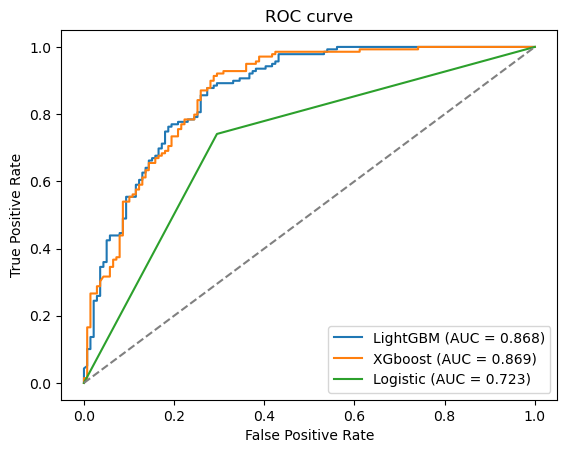

LightGBM AUCスコア = 0.868
XGboost AUCスコア = 0.869
Logistic AUCスコア = 0.723


In [14]:
#ライブラリをインポート
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, roc_curve, roc_auc_score

# テストデータの予測確率を取得
y_test_pred_proba_light = model.predict(X_test)
y_test_pred_proba_xgb = model_xgb.predict(dtest)  # dtestはXGboost用のデータセット
y_test_pred_proba_lr = model_lr.predict(X_test_lr) 


# AUCスコアを計算
auc_score_light = roc_auc_score(y_test, y_test_pred_proba_light)
auc_score_xgb = roc_auc_score(y_test, y_test_pred_proba_xgb)
auc_score_lr = roc_auc_score(y_test_lr, y_test_pred_proba_lr)



# AUC曲線をプロット
# lightGBMの描写
fpr_light, tpr_light, _ = roc_curve(y_test, y_test_pred_proba_light)
plt.plot(fpr_light, tpr_light, label='LightGBM (AUC = {:.3f})'.format(auc_score_light))

# XGboostの描写
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_test_pred_proba_xgb)
plt.plot(fpr_xgb, tpr_xgb, label='XGboost (AUC = {:.3f})'.format(auc_score_xgb))

# ロジスティック回帰の描写
fpr_lr, tpr_lr, _ = roc_curve(y_test_lr, y_test_pred_proba_lr)
plt.plot(fpr_lr, tpr_lr, label='Logistic (AUC = {:.3f})'.format(auc_score_lr))

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()

# 保存と表示
plt.savefig('roc_curve_notboold.png', dpi=300)
plt.show()

# AUCスコアを表示
print('LightGBM AUCスコア = {:.3f}'.format(auc_score_light))
print('XGboost AUCスコア = {:.3f}'.format(auc_score_xgb))
print('Logistic AUCスコア = {:.3f}'.format(auc_score_lr))
